In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import seaborn as sns
sns.set(font_scale = 1.5)

import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings("ignore")

In [2]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
buoy_data = pd.read_csv('../data-sources/forecasting-floats/cleaned-buoy-data.csv')

In [4]:
def plot_autocorrs(data, buoy_id, feature, test_size, lags, alpha=0.05):
    se = stats.norm().ppf(1-alpha/2)/np.sqrt(len(data[data['Spot Id'] == buoy_id][feature][:-test_size][1:-2]))
    fig, ax = plt.subplots(nrows=2, figsize=(15, 8), sharey=True)
    plot_acf(data[data['Spot Id'] == buoy_id][feature][:-test_size][1:-2], lags=lags, alpha=alpha, ax=ax[0])
    ax[0].hlines(np.array([-1, 1])*se, 1, lags, linestyles='--', lw=1)
    ax[0].set_title(f'{feature} Autocorrelation')
    plot_pacf(data[data['Spot Id'] == buoy_id][feature][:-test_size][1:-2], lags=lags, alpha=alpha, ax=ax[1], method='ywmle')
    ax[1].hlines(np.array([-1, 1])*se, 1, lags, linestyles='--', lw=1)
    ax[1].set_title(f'{feature} Partial Autocorrelation')
    plt.show()

In [5]:
def plot_diff(data, buoy_id, test_size, feature):
    fig, ax = plt.subplots(nrows=3, figsize=(15, 12))
    data[data['Spot Id'] == buoy_id][feature][:-test_size].plot(kind='line', color=['crimson'], lw=2, ax=ax[0])
    ax[0].set_title(f'{feature}')
    data[data['Spot Id'] == buoy_id][feature][:-test_size].diff()[1:].plot(kind='line', color=['crimson'], lw=2, ax=ax[1])
    ax[1].set_title(f'{feature} Differenced Once')
    data[data['Spot Id'] == buoy_id][feature][:-test_size].diff().diff()[2:].plot(kind='line', color=['crimson'], lw=2, ax=ax[2])
    ax[2].set_title(f'{feature} Differenced Twice')
    plt.show()

In [13]:
def make_predict(data, buoy_id, feature, order, start_p, end_p):
    series = data[data['Spot Id'] == buoy_id][feature].reset_index(drop=True)
    model = sm.tsa.statespace.SARIMAX(series[:-48], order=order, trend='c')
    results = model.fit(maxiter=5000)
    print(results.summary())
    
    preds = results.predict(start=0, end=len(series[:-48])+end_p, dynamic=False)
    #preds_dyn = results.predict(start=len(series[:-48])-start_p, end=len(series[:-48])+end_p, dynamic=True)
    
    ci = results.get_prediction(start=-120, end=len(series)+end_p).conf_int(alpha=0.05)
    
    fig, ax = plt.subplots(figsize=(15, 8))
    series[-168:-end_p+1].plot(c='b', label=f'Training {feature}', lw=5, ax=ax)
    series[-end_p:].plot(c='k', label=f'Testing {feature}', lw=5, ax=ax)
    preds[-168:].plot(c='g', ls='--', lw=2.5, label='Non-dynamical Foreacasting', ax=ax)
    #preds_dyn.plot(c='r', ls='-.', label='Dynamical Forecasting', ax=ax)
    ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:, 1], alpha=0.3)
    plt.legend(loc=[1.1, 0])
    results.plot_diagnostics(figsize=(15, 15))
    plt.show()

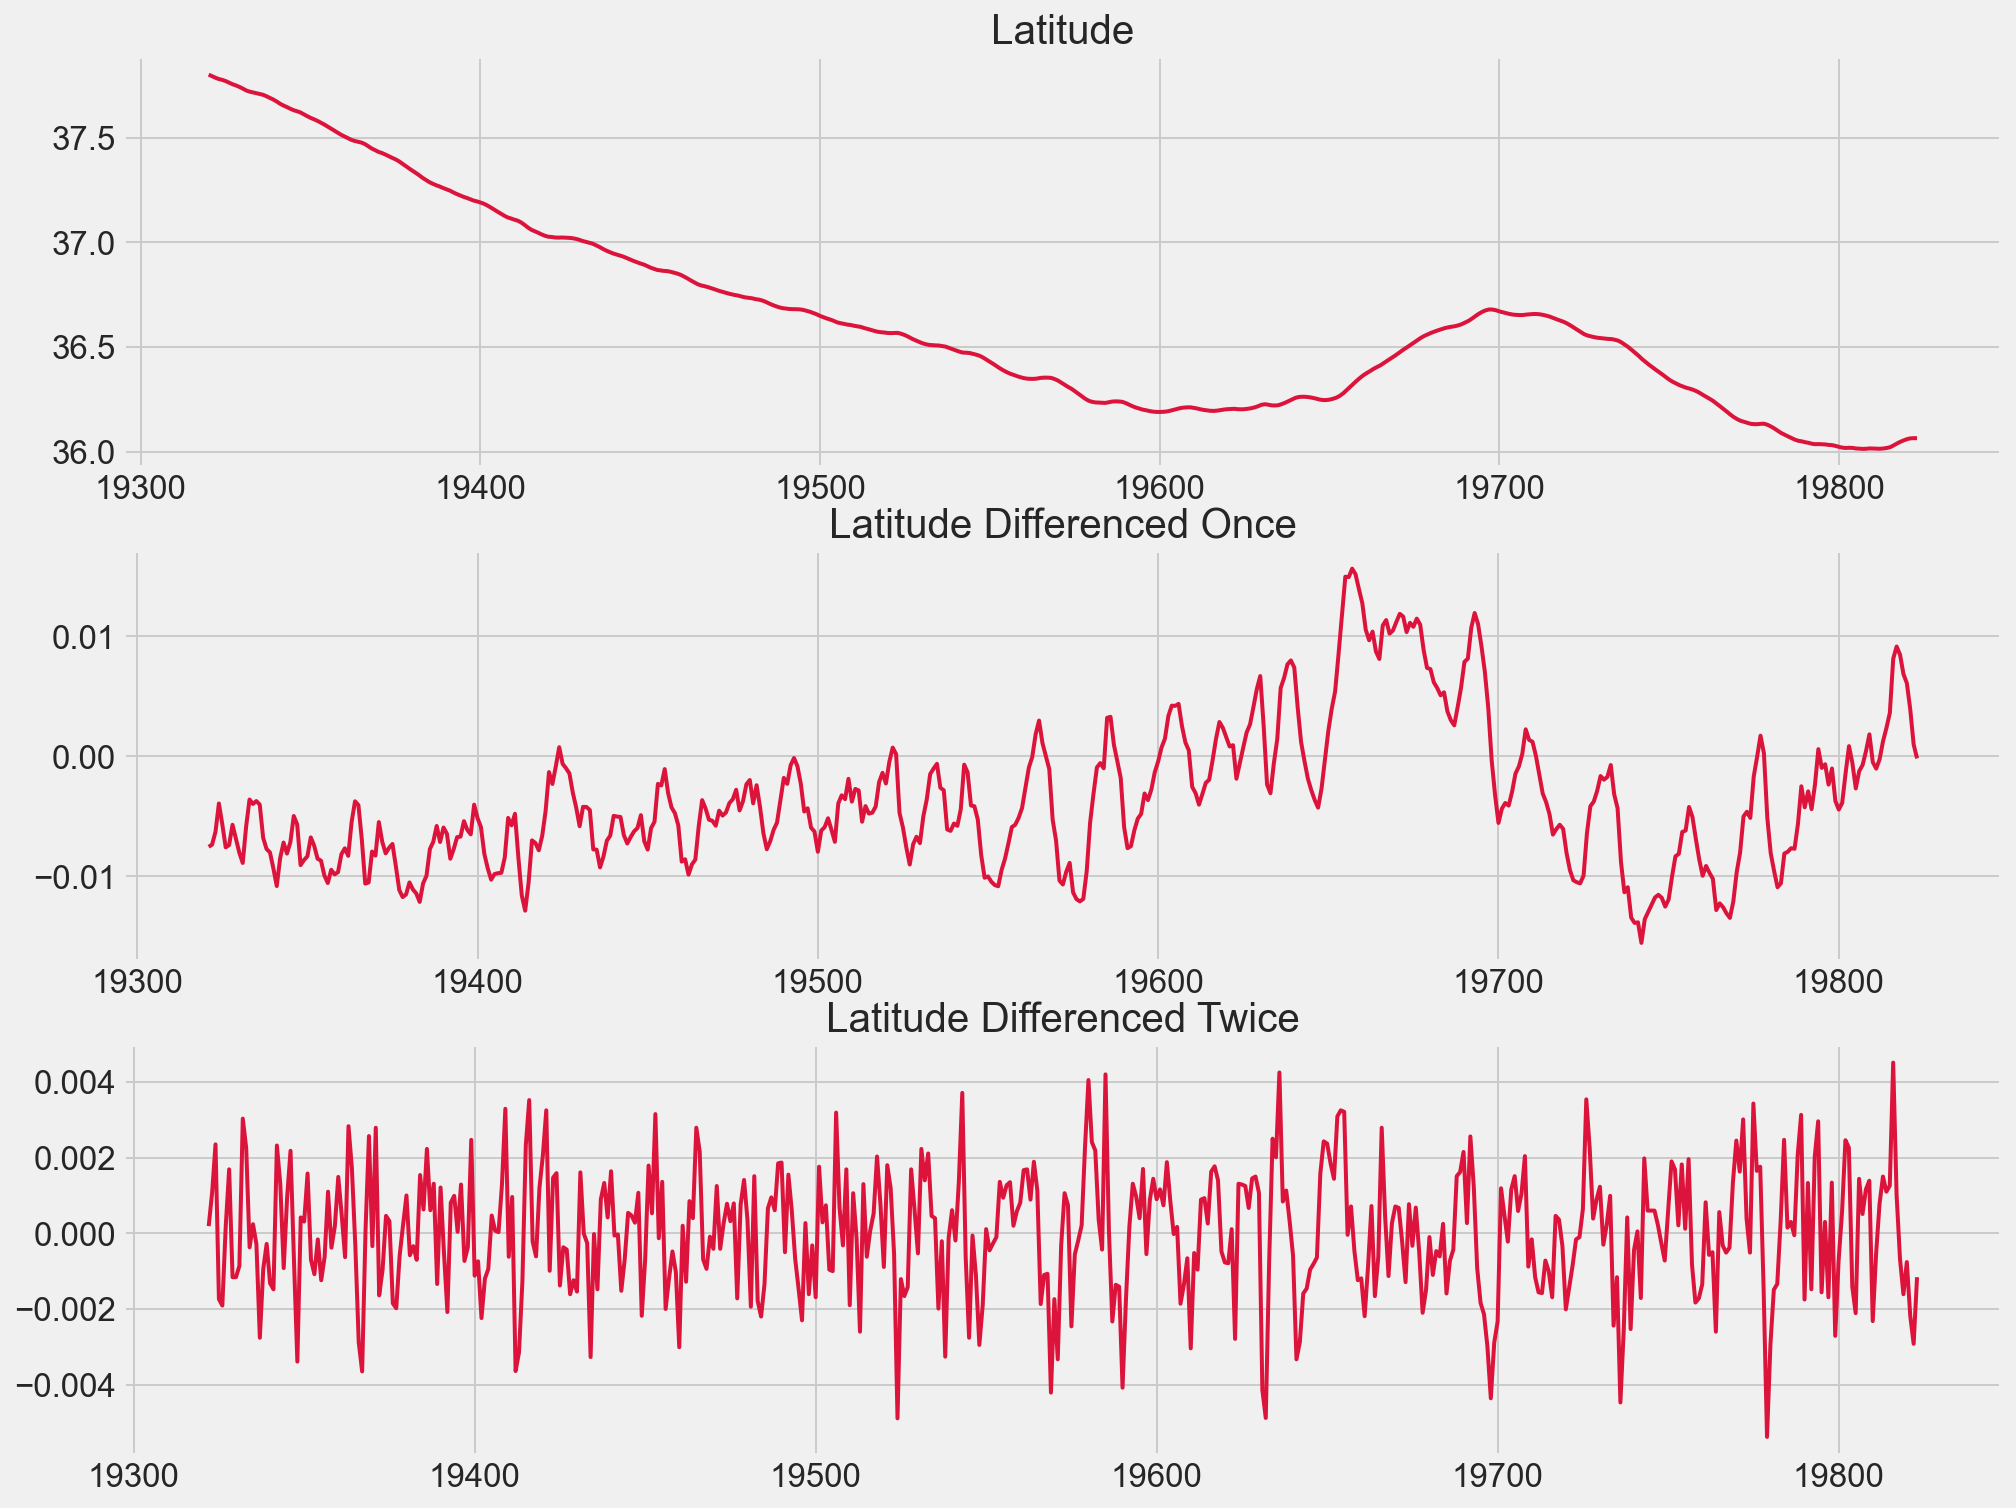

In [14]:
plot_diff(buoy_data, 35, 48, 'Latitude')

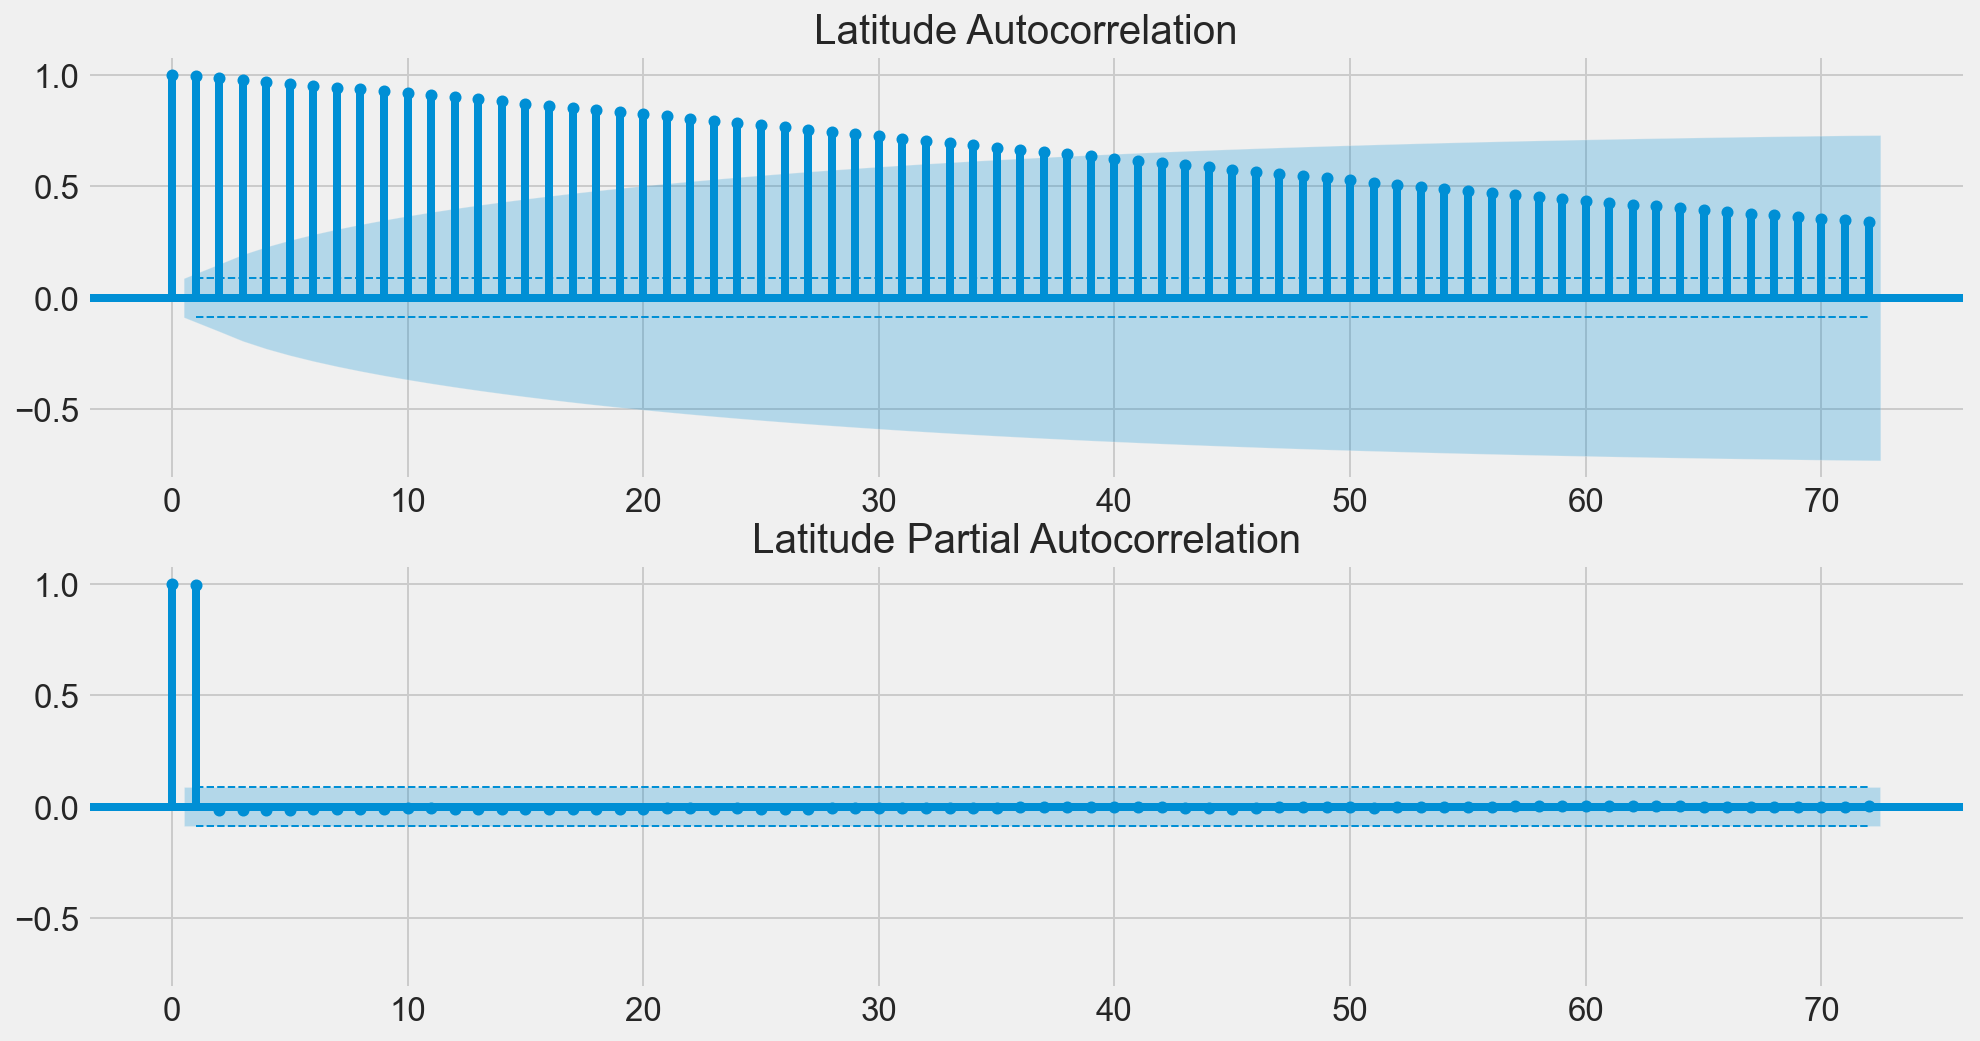

In [15]:
plot_autocorrs(buoy_data, 35, 'Latitude', 48, 72)

                               SARIMAX Results                                
Dep. Variable:               Latitude   No. Observations:                  504
Model:              SARIMAX(37, 2, 1)   Log Likelihood                2579.512
Date:                Wed, 24 Nov 2021   AIC                          -5079.024
Time:                        14:15:45   BIC                          -4910.280
Sample:                             0   HQIC                         -5012.821
                                - 504                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.085e-05   8.19e-05      0.377      0.706      -0.000       0.000
ar.L1          0.1322      0.811      0.163      0.870      -1.458       1.722
ar.L2          0.0467      0.211      0.222      0.8

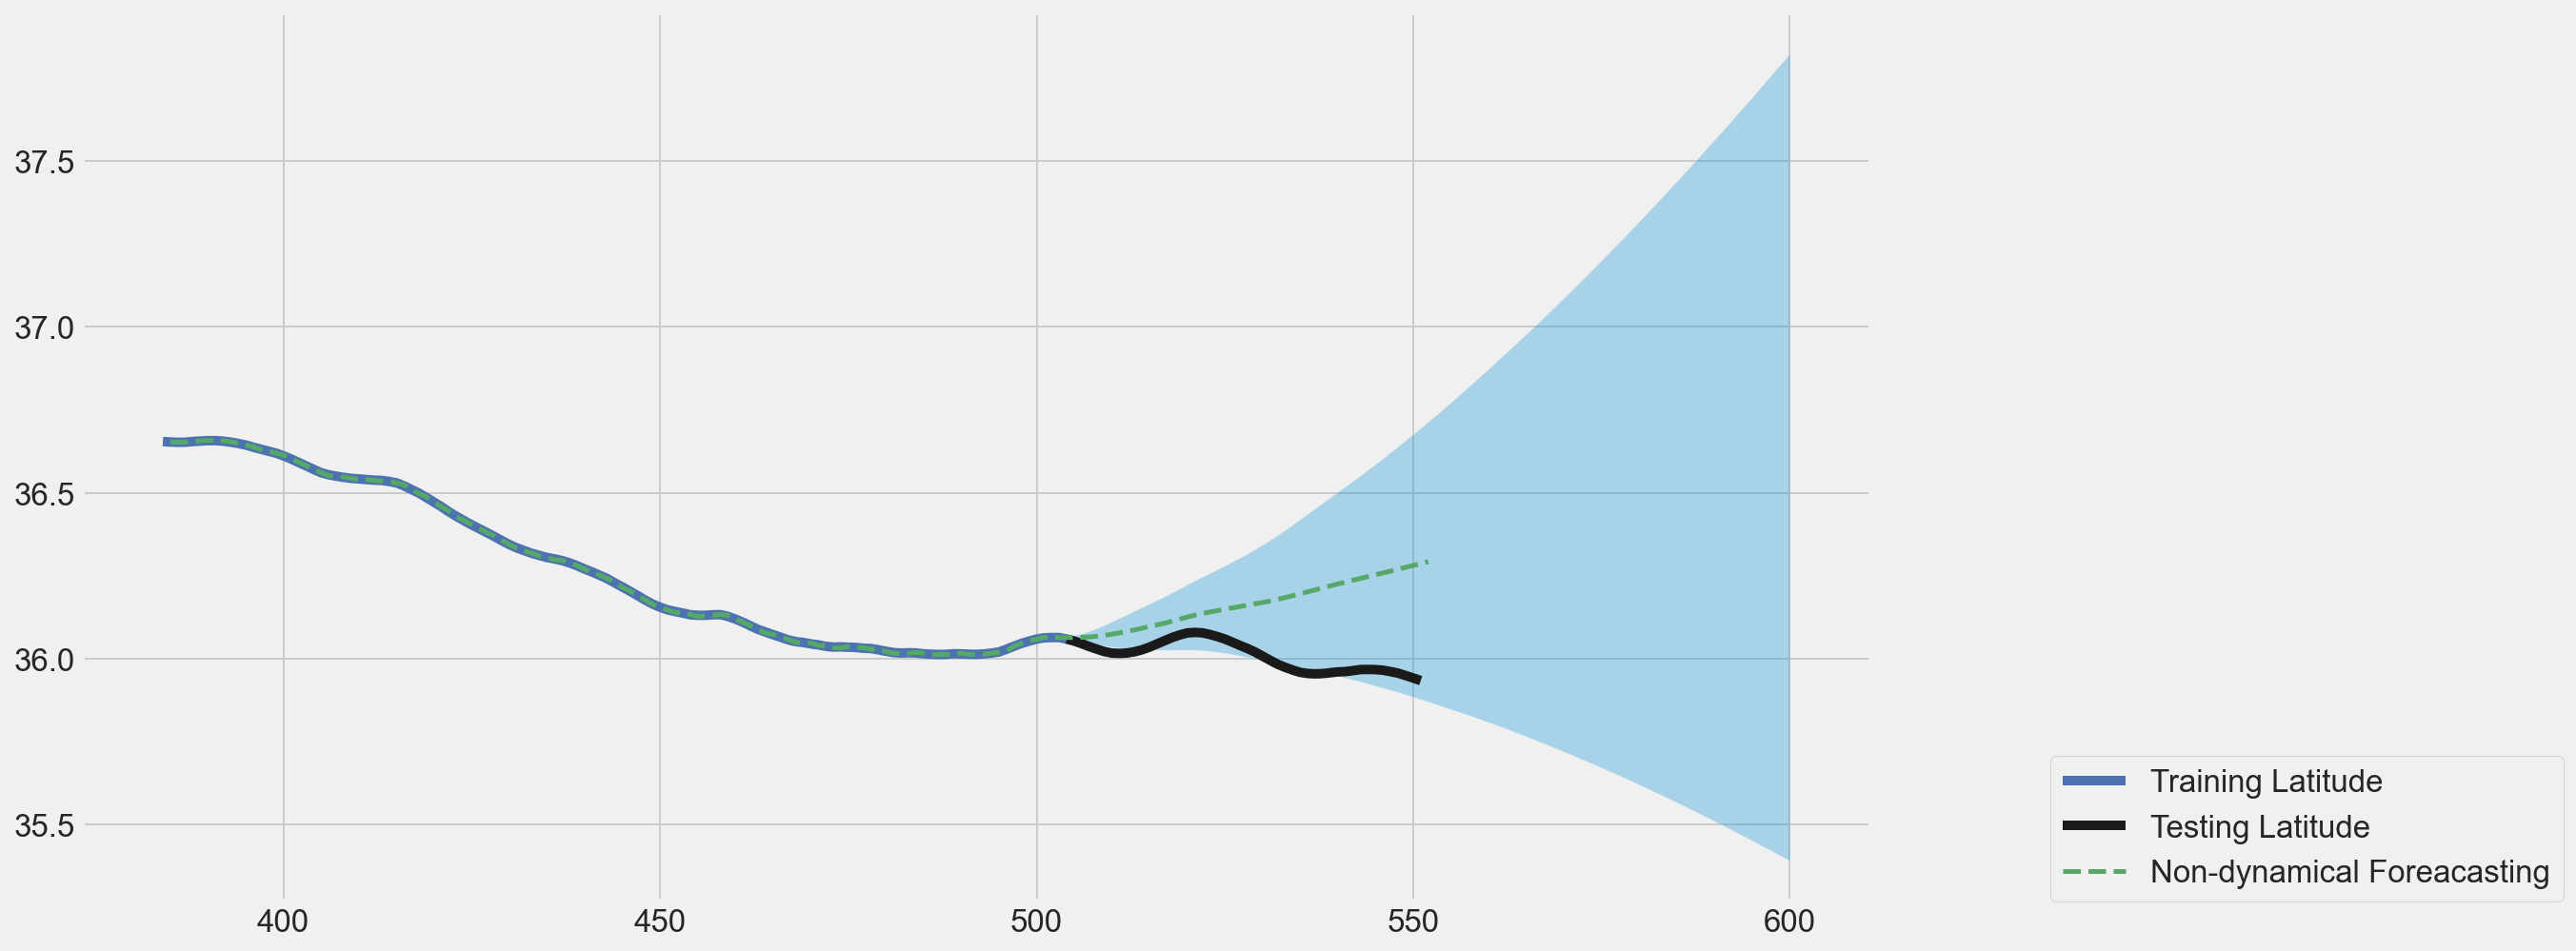

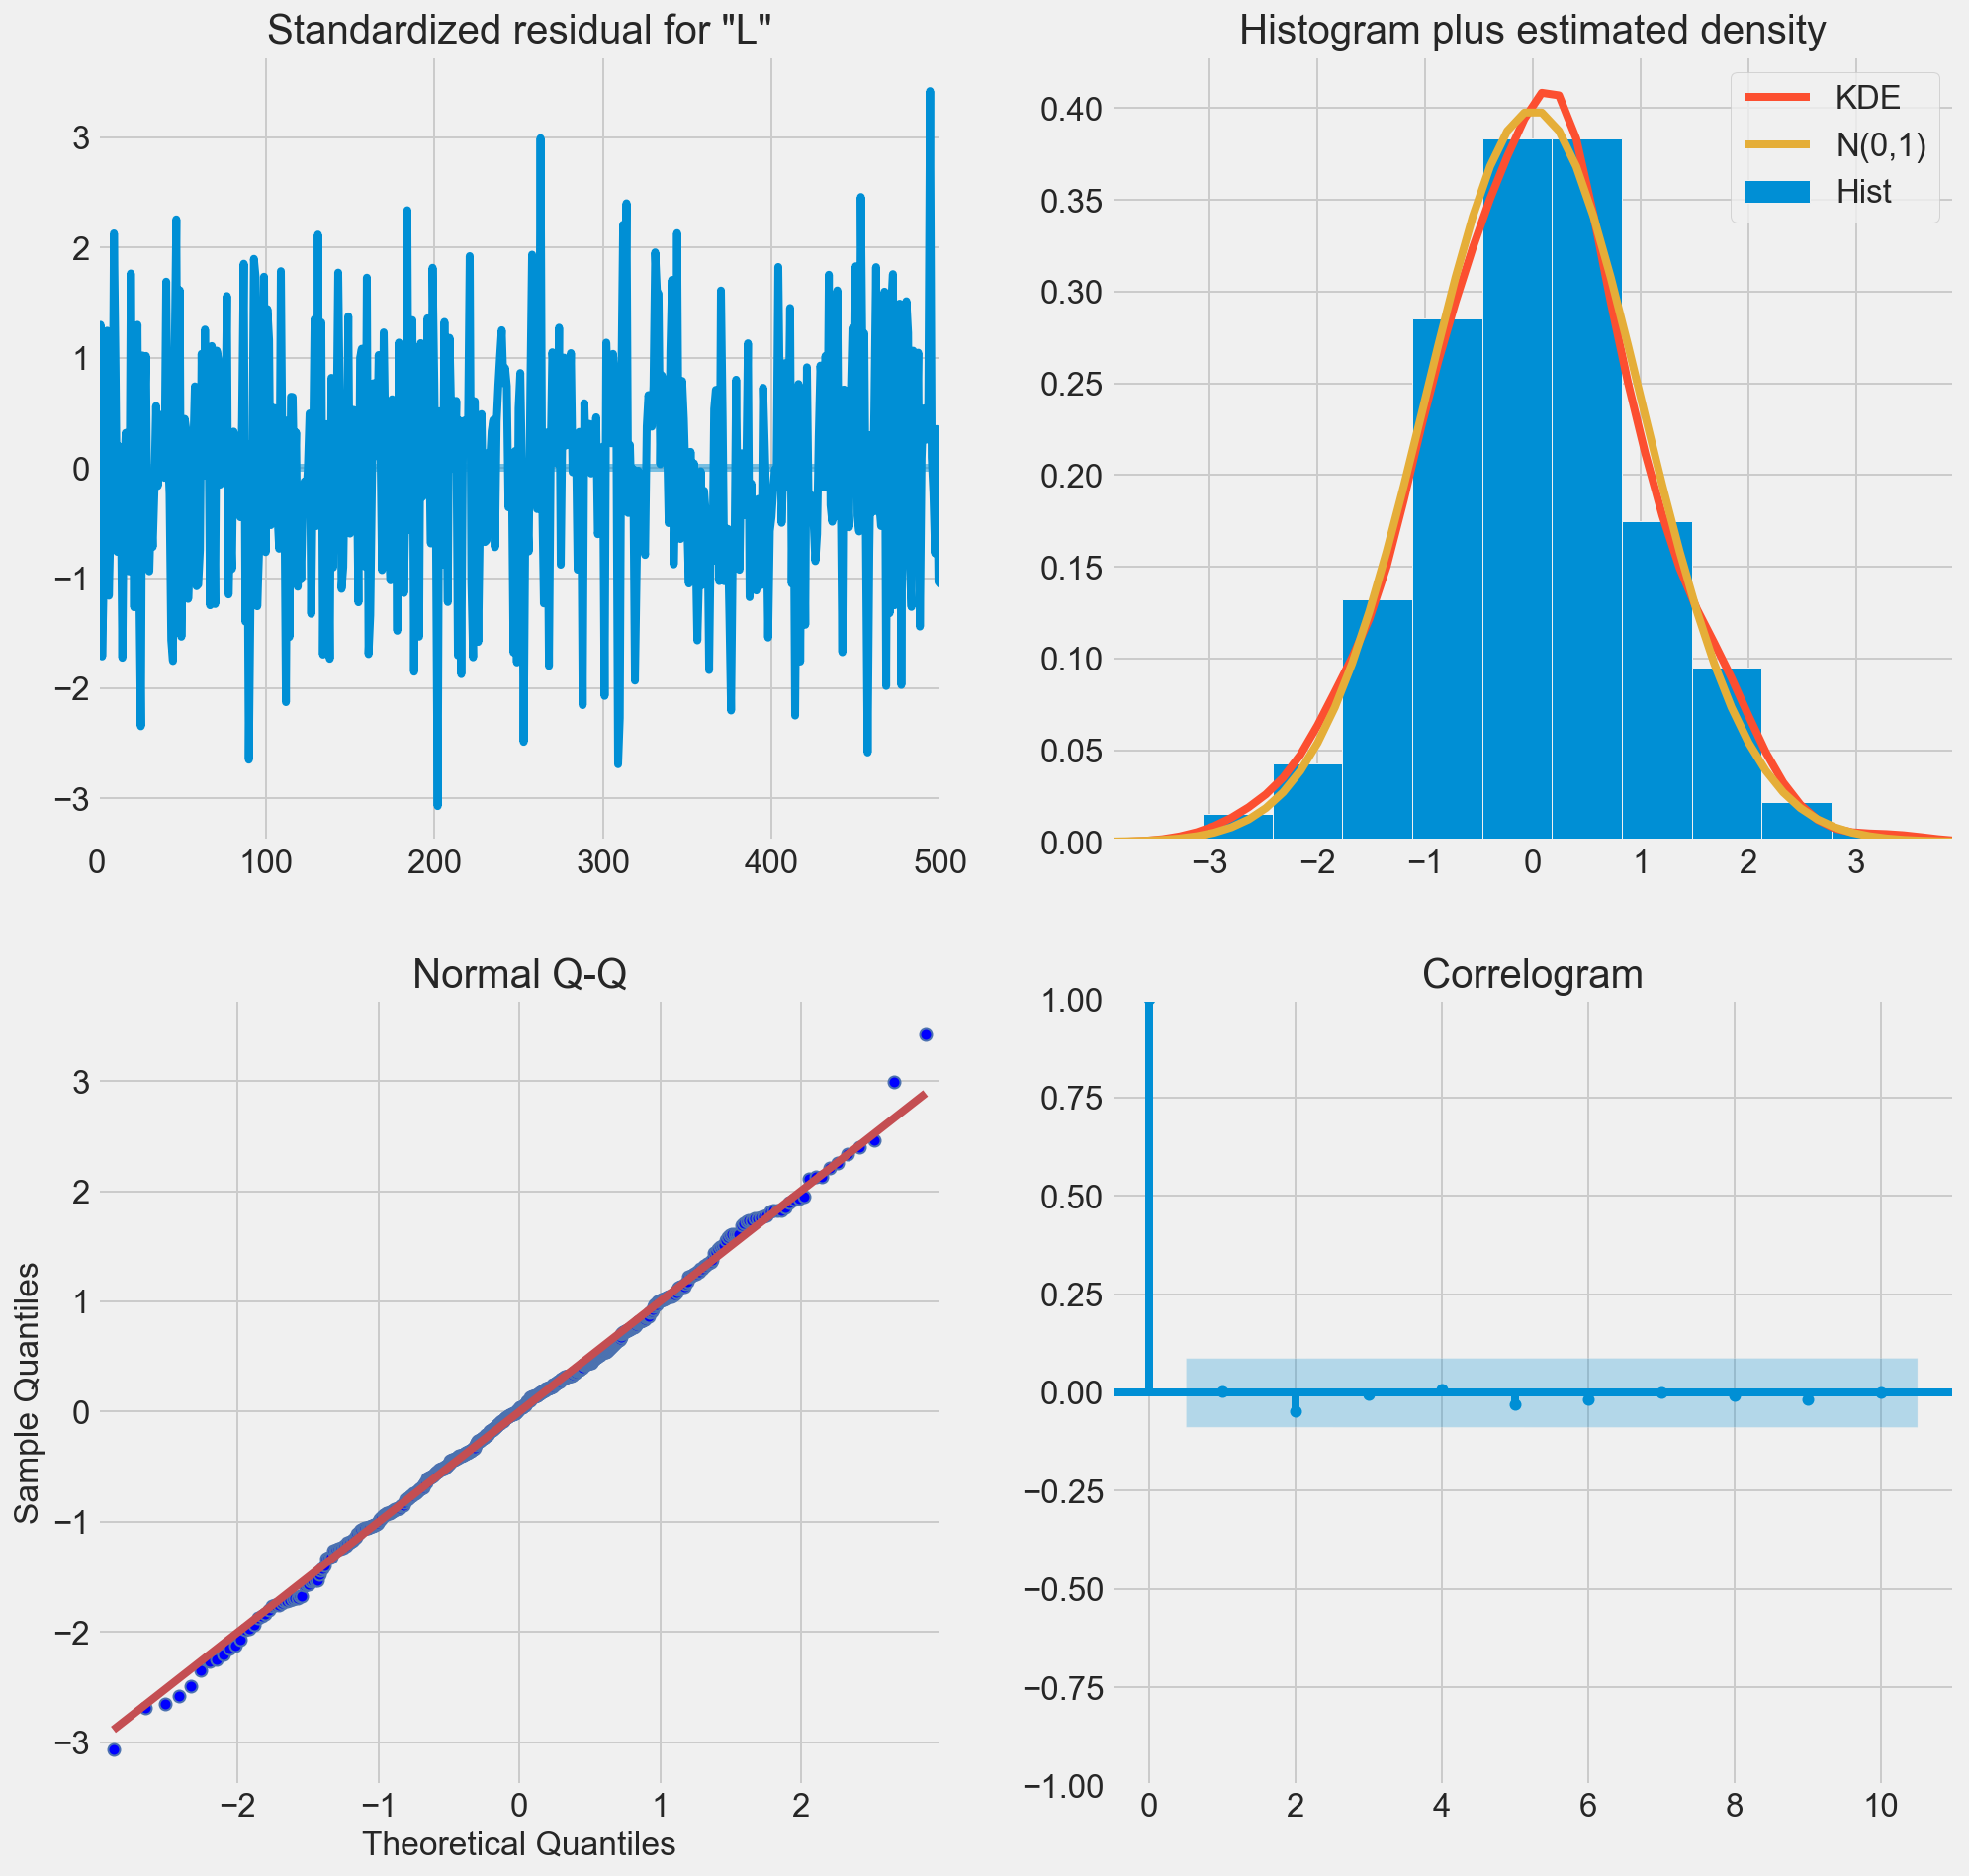

In [16]:
make_predict(data=buoy_data, buoy_id=35, feature='Latitude', order=(37, 2, 1), start_p=24, end_p=48)

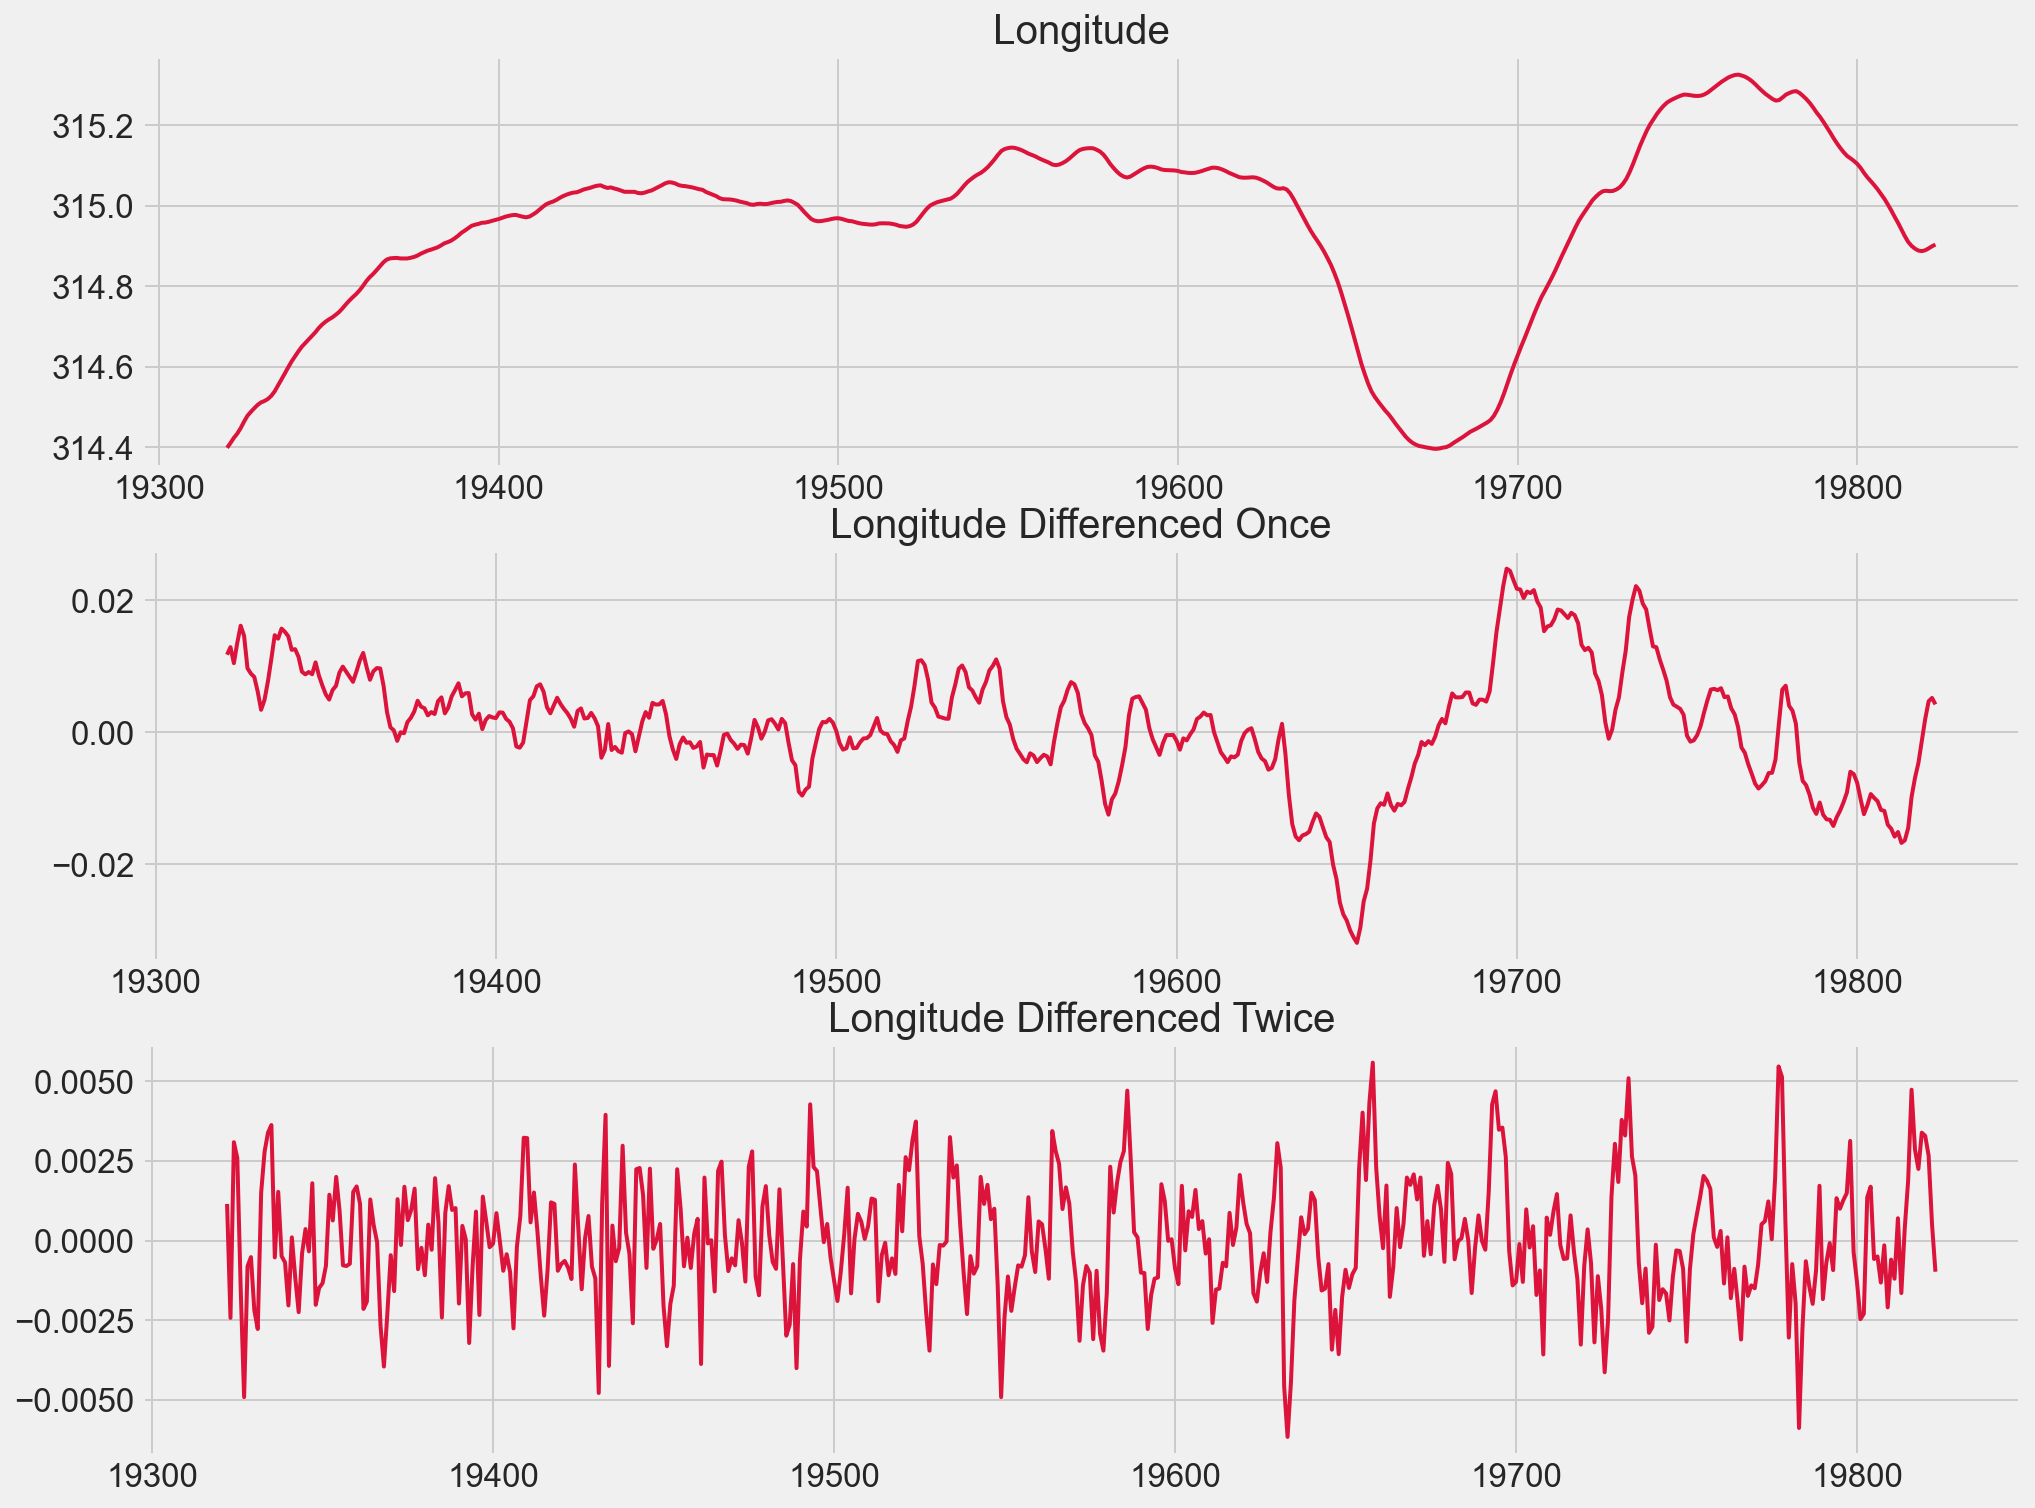

In [17]:
plot_diff(buoy_data, 35, 48, 'Longitude')

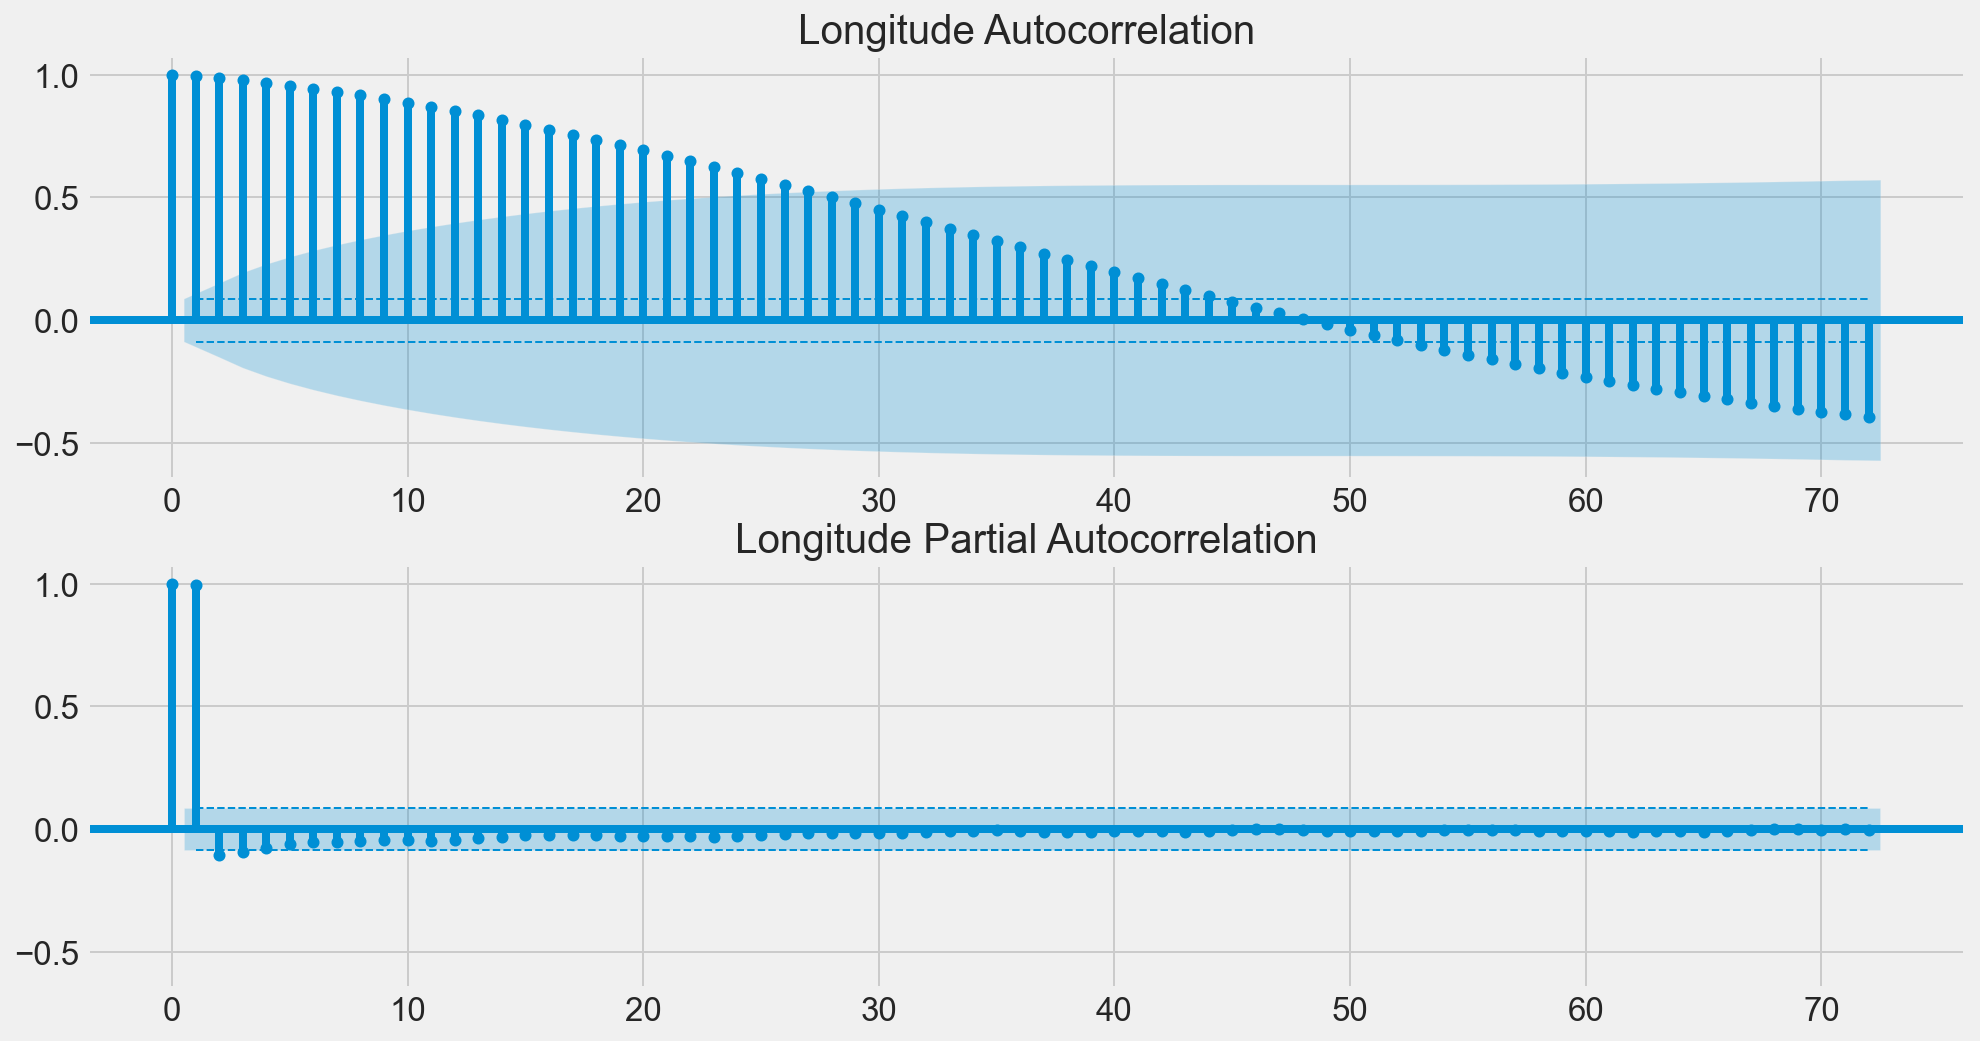

In [18]:
plot_autocorrs(buoy_data, 35, 'Longitude', 48, 72)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:              Longitude   No. Observations:                  504
Model:              SARIMAX(26, 2, 4)   Log Likelihood                2538.331
Date:                Wed, 24 Nov 2021   AIC                          -5012.662
Time:                        14:15:54   BIC                          -4877.667
Sample:                             0   HQIC                         -4959.699
                                - 504                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -1.84e-05   9.86e-05     -0.187      0.852      -0.000       0.000
ar.L1          0.2572      1.118      0.230      0.818      -1.933       2.448
ar.L2          0.0463      1.137      0.041      0.9

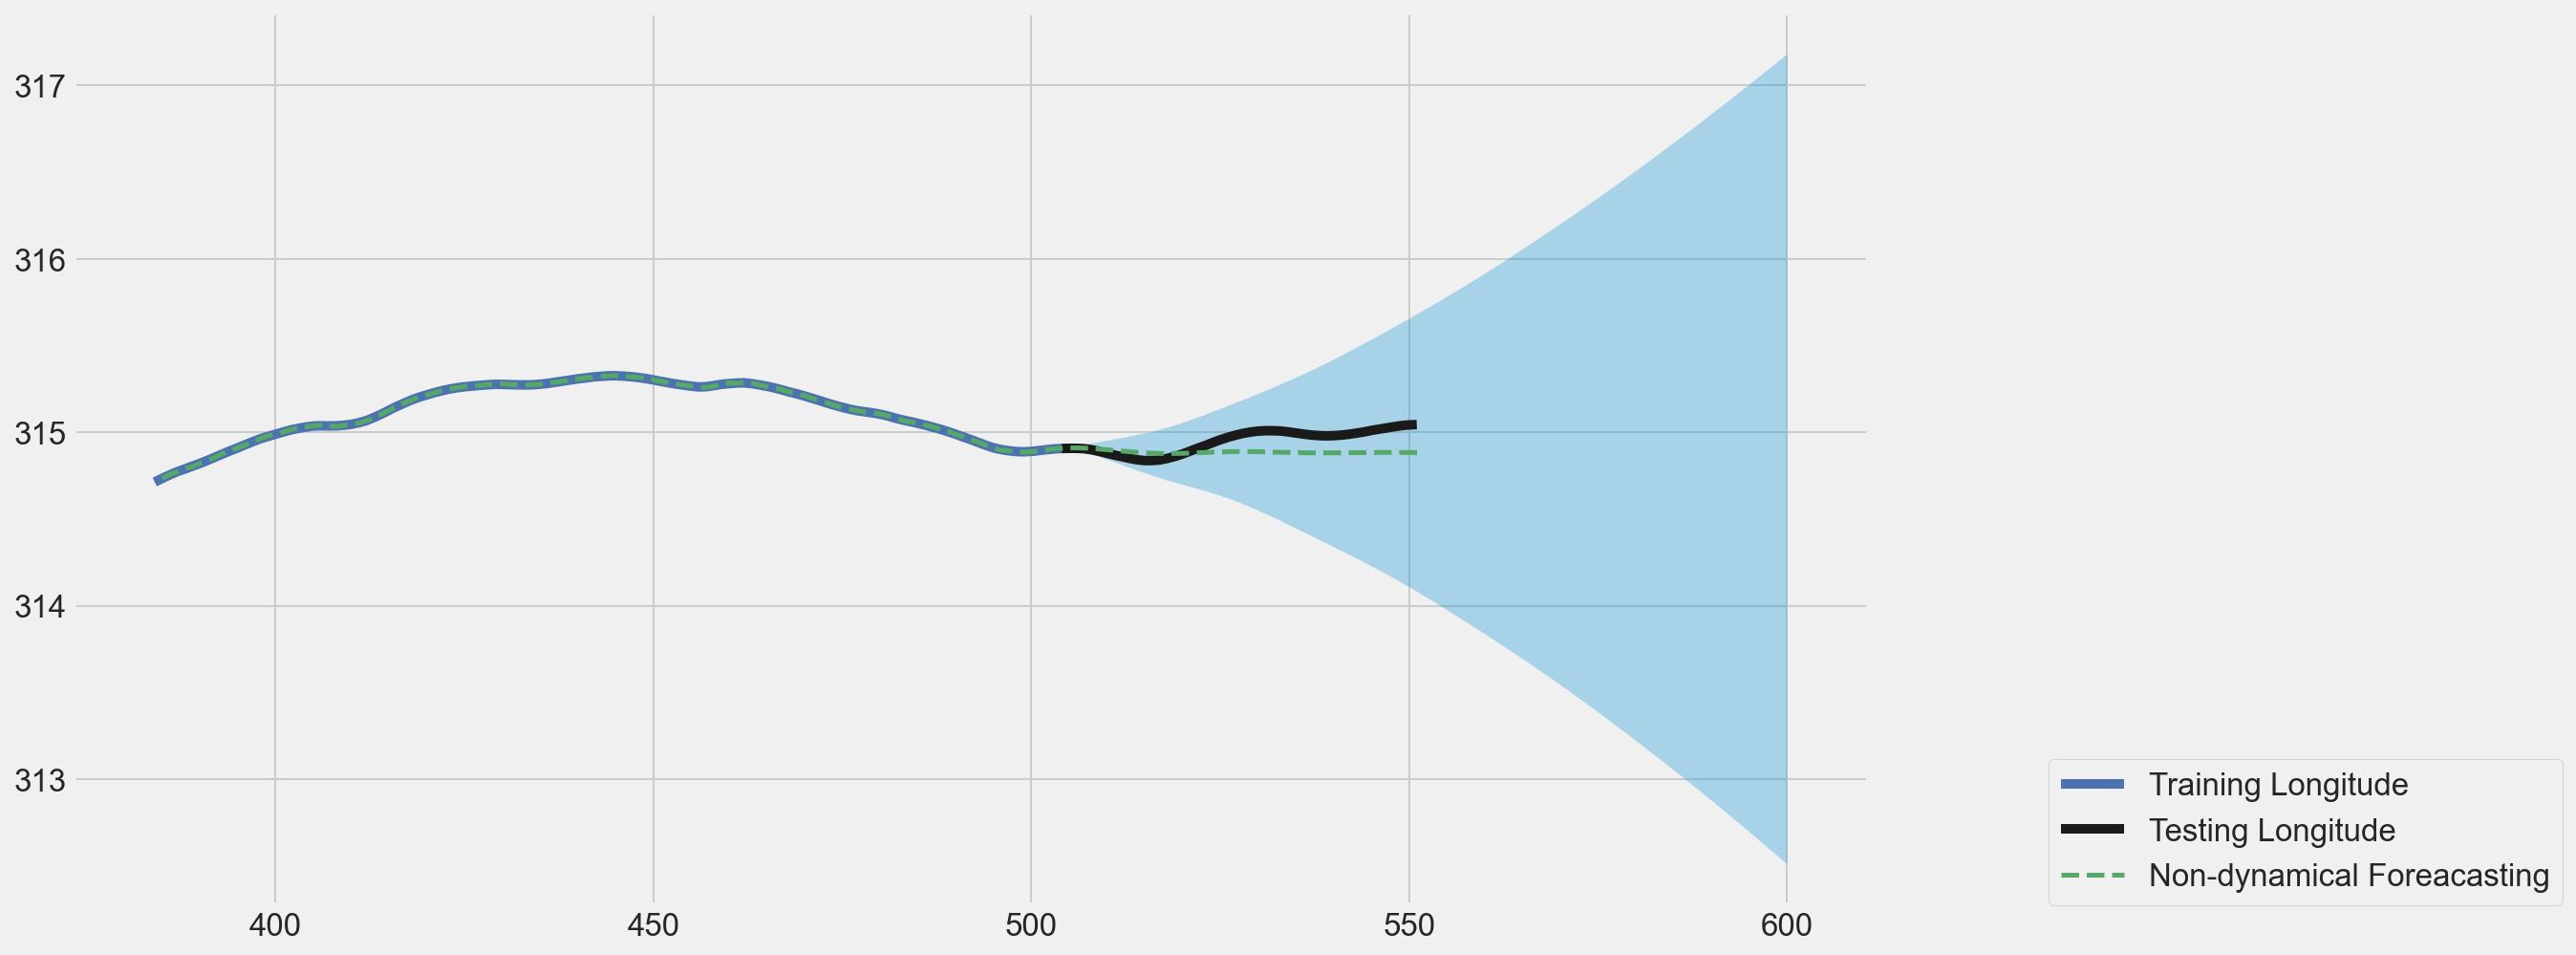

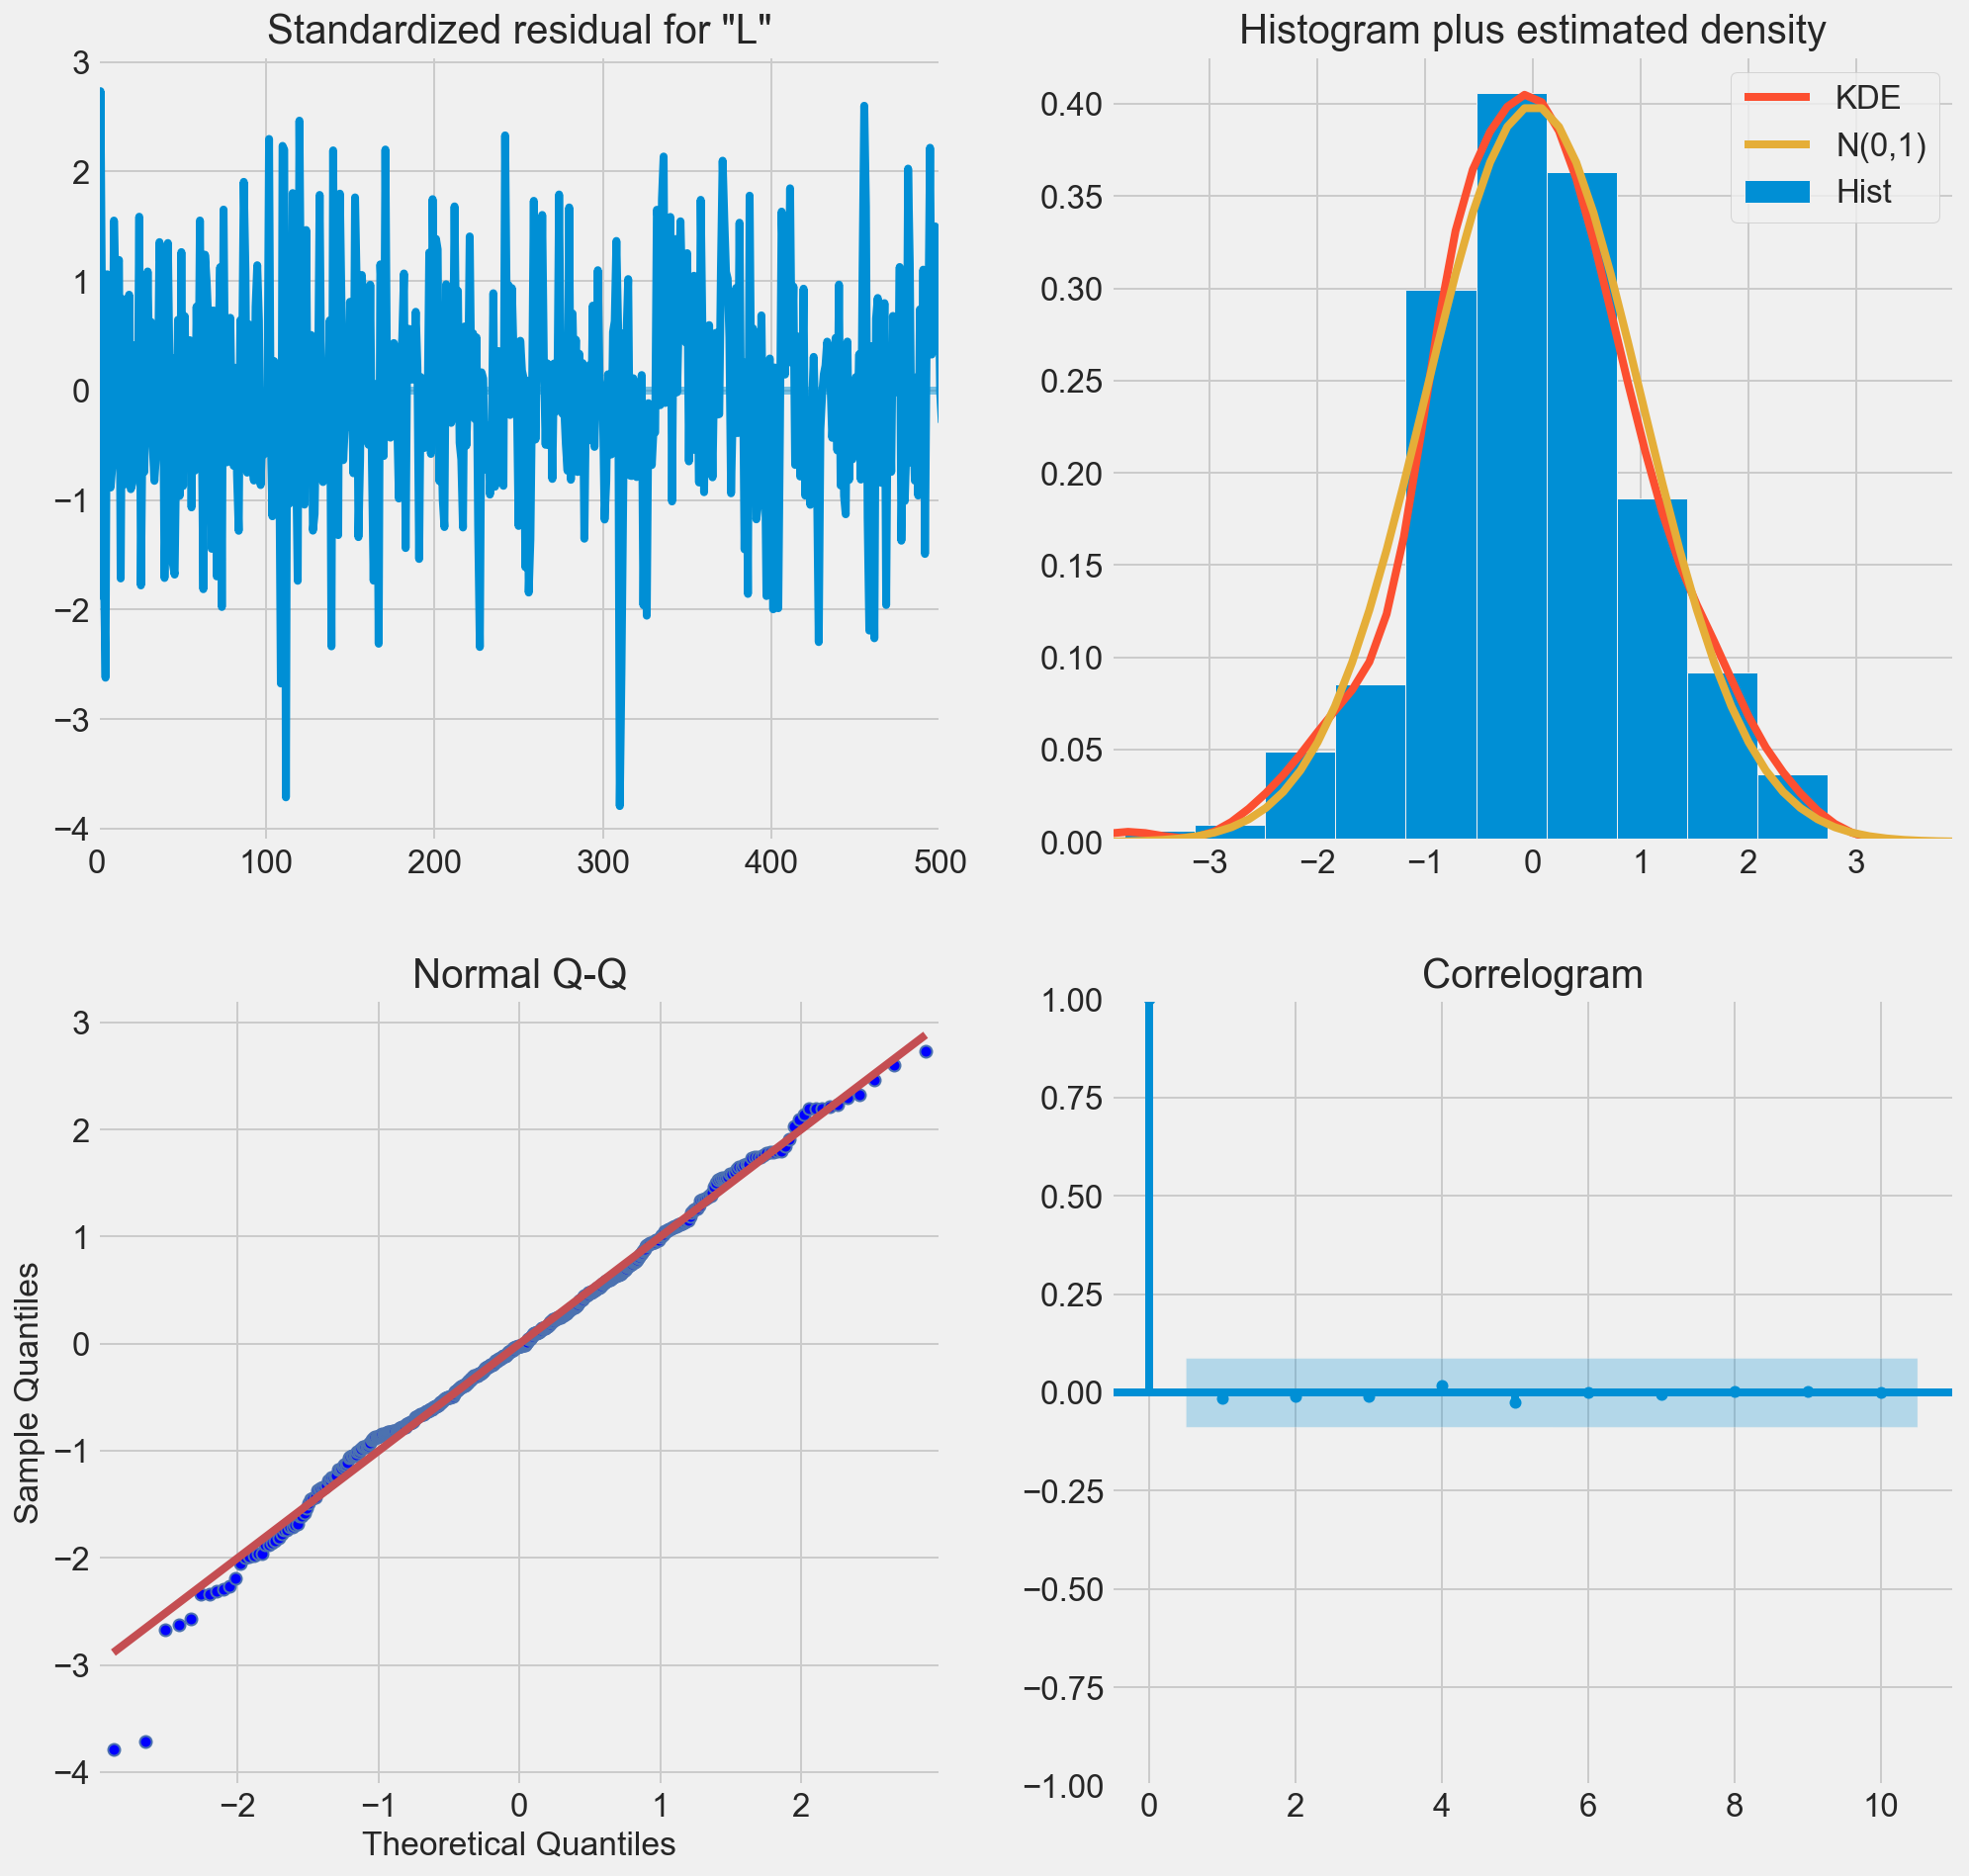

In [19]:
make_predict(data=buoy_data, buoy_id=35, feature='Longitude', order=(26, 2, 4), start_p=48, end_p=48)